# Portfolio Replication Problem

A bond benchmark portfolio with **N** securities will have an aggregate yield and duration modified duration measurement. 

We would like to create a subset (“*replication*”) portfolio with a smaller numbre of bonds from the broader benchmark, such that we minimize the yield and duration differential between the provided benchmark portfolio and the replication portfolio. We will be using the J.P. Morgan Government Bond–Emerging Market Index (GBI-EM) series as our bond benchmark for this excercise in portfolio replication.

However, we will be dividing this problem into two parts **A)** where we select the most liquid subset of tradable bonds from the benchmark to be in the replication portfolio, and **B)** where we will determine the appropriate weight for each bond such that we match the benchmark's yield and duration. 

In [1]:
import math
import pandas as pd 
import numpy as np 
import gurobipy as gp 
import matplotlib.pyplot as plt

In [2]:
# Load in the J.P. Morgan GBI-EM Global Bond Index composition
df = pd.read_csv('JPM_COMP_GBI_EMGLOBAL_DIV_2023-07-31.csv')
df.head()

,BIG ID,Local ID,Bond Description,Liquidity,Maturity,Mat Sect,Price,Accr Int,Total Rtn,1D Rtn,...,YTD Rtn USD,1D Rtn EUR,MTD Rtn EUR,12M Rtn EUR,YTD Rtn EUR,Inclusion(%),Inclusion Direction,Country,Weight % - FOM,Weight % - Daily USD Rtrn
0,XCN0276,CND10003VNX4,China 3.2700% CGB Nov 2030,Traded,19-Nov-30,'7-10',105.037650,0.657554,113.078196,-0.088492,...,0.366911,0.243501,1.010024,-8.919546,-2.846505,100,-,CN,0.273611,0.273611
1,XCN0274,CND10003R702,China 3.0200% CGB Oct 2025,Traded,22-Oct-25,'1-3',101.987600,2.341534,110.880765,-0.012676,...,-0.660025,0.319568,0.877444,-10.325500,-3.840562,100,-,CN,0.263798,0.263798
2,XCN0270,CND100036Q75,China 2.6800% CGB May 2030,Traded,21-May-30,'5-7',100.283235,0.524348,110.665101,-0.091410,...,0.023284,0.240573,0.767244,-9.512708,-3.179130,100,-,CN,0.258868,0.258868
3,XCN0269,CND100037XX3,China 2.8500% CGB Jun 2027,Traded,4-Jun-27,'3-5',101.795800,0.451639,110.709141,-0.035009,...,-0.300013,0.297161,0.839340,-10.065617,-3.492076,100,-,CN,0.257227,0.257227
4,XCN0267,CND100031JZ0,China 1.9900% CGB Apr 2025,Traded,9-Apr-25,'1-3',99.771850,0.619836,105.481863,-0.022893,...,-0.869090,0.309317,0.785338,-10.531253,-4.042934,100,-,CN,0.250150,0.250150


In [6]:
# Select relevant columns to be examined for the bond portfolio (B)
B = df[['ISIN', 'Bond Description', 'Country', 'Currency', 'Mod Dur', 'Yield', 
        'Intra-Country Weight', 'Norm Weight', 'Liquidity Score']].copy()
B.loc[:, 'Liquidity Score'] = B.loc[:, 'Liquidity Score'].apply(lambda x: x**-1)
B = B.set_index('ISIN')

KeyError: "['Intra-Country Weight', 'Norm Weight', 'Liquidity Score'] not in index"

In [ ]:
B.head()

**Liquidity Scores** corresponds with the tradability of a given bond within a country of issuance, e.g. CND10003VNX4 China bond has a liquidity score of 1.0, implying that it is more liquid compared to other bonds from China in the benchmark. There are three liquidity score assignments 1, 0.5, and 0.33. 	  

In [ ]:
countries = B.Country.unique()

# Helpful dictionaries for analysis 
# 1. cntry_agg_wgt = Bond weight aggregated by country
# 2. cntry_agg_cnt = Bond number aggregated by country
# 3. cntry_bond_map = Bonds belonging to each country

cntry_agg_wgt = B.groupby('Country')['Norm Weight'].sum().to_dict()
cntry_agg_cnt = B.groupby('Country')['Norm Weight'].count().to_dict()
cntry_bond_map = {c: B[B.Country == c].index.tolist() for c in countries}

## A) Subset Determination
**Linear Assignment Problem: Determing the most liquid subset of bonds to include in the replication basket**

In [ ]:
# Model for determining the subset of bonds
m1 = gp.Model("rep_basket")

In [ ]:
# DECISION VARIABLES
alloc_bin = {(i, B.loc[i]['Country']) : m1.addVar(vtype=gp.GRB.BINARY, name=f"{i}_bin") for i in B.index}
N = B.index.size

# The number of bonds in the portfolio
n = 50 

In [ ]:
# OBJECTIVE: Weighted liquidity score (higher bond weight higher value)
m1.setObjective(sum(alloc_bin[x] * B.loc[x[0]]['Liquidity Score'] for x in alloc_bin.keys()), gp.GRB.MAXIMIZE)

In [ ]:
# CONSTRAINT (1): Minimum country investment level, at least one bond invested per country
for c in countries:
    m1.addConstr(sum([alloc_bin[(isin, c)] for isin in cntry_bond_map[c]]) >= 1)

# CONSTRAINT (2): Total number of bonds in the replicable portfolio
m1.addConstr(sum(alloc_bin[x] for x in alloc_bin.keys()) == n)

# OPTIMIZE
m1.optimize() 

In [ ]:
# Creation of the subset portfolio with corresponding liquidity assignment
subset_portfolio = pd.DataFrame({x[0]: [alloc_bin[x].x] for x in alloc_bin.keys()}, index=['Inclusion/Exclusion']).T
subset_portfolio = subset_portfolio[subset_portfolio['Inclusion/Exclusion'] == 1]
subset_portfolio = subset_portfolio.join(B[['Bond Description', 'Country', 'Liquidity Score']])

In [ ]:
subset_portfolio.to_csv('portfolio_assignment.csv')
subset_portfolio.head()

## B) Replication Weights

**Linear Weighting Problem: Determining the appropriate weight to assign each bond such that we mirror the benchmark**

In [ ]:
# Model for determining the weights for each subset
m2 = gp.Model("rep_weight")

In [4]:
# The allocation weight trigger for replicatoin basket
alloc_wgt = {(i, B.loc[i]['Country']) : m2.addVar(vtype=gp.GRB.CONTINUOUS, name=f"{i}_wgt") 
             for i in subset_portfolio.index}

NameError: name 'subset_portfolio' is not defined

In [5]:
# Construct static yield and duration statistics from the benchmark portfolio 
yeild_b = (B['Yield'] * B['Norm Weight']).sum() 
duration_b = (B['Mod Dur'] * B['Norm Weight']).sum()  

# DECISION VARIABLES: Construct floating yield and duration statistics from the replication portfolio
yeild_r = sum(alloc_wgt[x] * B.loc[x[0]]['Yield'] for x in alloc_wgt)  
duration_r = sum(alloc_wgt[x] * B.loc[x[0]]['Mod Dur'] for x in alloc_wgt)  

# OBJECTIVE: Weighted liquidity score (higher bond weight higher value)
m2.setObjective((yeild_b - yeild_r)**2 + (duration_b - duration_r)**2, gp.GRB.MINIMIZE)

NameError: name 'B' is not defined

In [15]:
# Assign the maximum weight present in the portfolio
max_base_wgt = B['Norm Weight'].sum()

# CONSTRAINT (1): Total weight constraint, weight must sum to the total weight constraints
m2.addConstr(sum(alloc_wgt[x] for x in alloc_wgt.keys()) == max_base_wgt)

# CONSTRAINT (2): Bond weight constraint, boundex 0 <= x <= 1
for x in alloc_wgt.keys():
    m2.addConstr(alloc_wgt[x] <= max_base_wgt)
    m2.addConstr(alloc_wgt[x] >= 0)

# CONSTRAINT (3): Maximum country allocation, no country weight can exceed its benchmark weight
for c in countries:
    m2.addConstr(sum(alloc_wgt[(isin, c)] if (isin, c) in alloc_wgt.keys() else 0 
                     for isin in cntry_bond_map[c]) == cntry_agg_wgt[c])

# OPTIMIZE
m2.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 121 rows, 50 columns and 200 nonzeros
Model fingerprint: 0xf1e5e43c
Model has 1275 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 3e+02]
  QObjective range [1e+01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+00]
Presolve removed 117 rows and 16 columns
Presolve time: 0.01s
Presolved: 4 rows, 34 columns, 65 nonzeros
Presolved model has 595 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 1.200e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    D

In [16]:
# Construct the replication portfolio with corresponding weights for optimization
replication_portfolio = pd.DataFrame({x[0]: [alloc_wgt[x].x] for x in alloc_wgt.keys()}, index=['Weights']).T
replication_portfolio = replication_portfolio.join(B[['Bond Description', 'Country', 'Mod Dur', 'Yield']])

In [17]:
replication_portfolio.to_csv('portfolio_weight.csv')
replication_portfolio.head()

,Weights,Bond Description,Country,Mod Dur,Yield
CND10004GNL8,9.999932e-02,China 2.6900% CGB Aug 2026,CN,2.813045,2.273167
CND10003W0P5,5.447083e-07,China 3.2800% CGB Dec 2027,CN,3.948456,2.306145
CND10004LLJ6,1.201280e-07,China 2.4700% CGB Sep 2024,CN,1.043150,1.960242
IDG000012006,1.879155e-06,Indonesia 8.3750% INDOG Mar 2024,ID,0.583225,5.941473
IDG000013707,1.515581e-06,Indonesia 6.5000% INDOGB Jun 2025,ID,1.726132,6.017978


## C) Portfolio Visualization

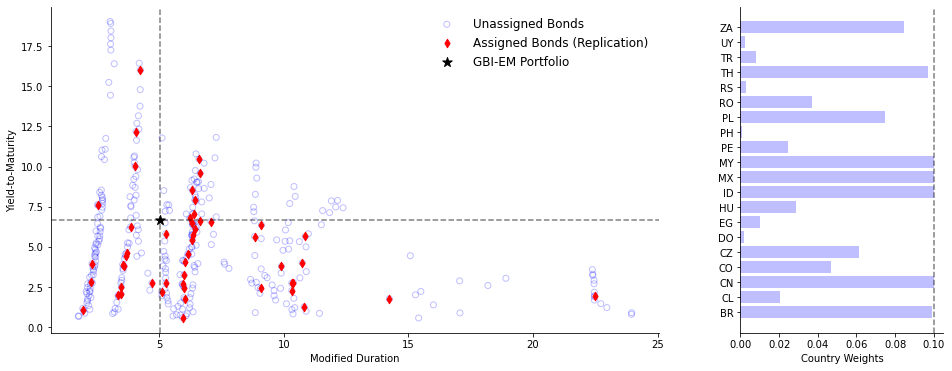

In [35]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
fig.set_figheight(6); fig.set_figwidth(16)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# Scatter plot for yields duration 
ax[0].scatter(B['Yield'], B['Mod Dur'], facecolors='none', edgecolor='b', alpha=0.25,
          label='Unassigned Bonds')
ax[0].scatter(replication_portfolio['Yield'], replication_portfolio['Mod Dur'], 
           facecolors='red', edgecolor='r', alpha=1, marker='d', label='Assigned Bonds (Replication)')

# Display the Aggregate GBI-EM Global Div yield & duration
ax[0].scatter( duration_b, yeild_b, marker='*', color='k', s=100, label='GBI-EM Portfolio')
ax[0].axvline(duration_b, color='k', ls='--', alpha=0.5)
ax[0].axhline(yeild_b, color='k', ls='--', alpha=0.5)

ax[0].set_xlabel('Modified Duration')
ax[0].set_ylabel('Yield-to-Maturity')
ax[0].legend(prop={'size': 12}, handletextpad=1.2, labelspacing=0.5, frameon=True, facecolor='white', edgecolor='white')

# Distribution of weights for each country
country_ylds = replication_portfolio.groupby('Country')['Weights'].sum()
ax[1].barh(country_ylds.index, country_ylds.values, color='blue', alpha=0.25)
ax[1].axvline(0.1, color='k', ls='--', alpha=0.5)

ax[1].set_xlabel('Country Weights')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.show()

In [30]:
# Number of bonds selected for each country
replication_portfolio.groupby('Country')[['Weights']].count().to_csv('portfolio_number.csv')

In [28]:
# Aggregate yield and duration methods
agg_yld = (replication_portfolio['Weights'] * replication_portfolio['Yield']).sum()
agg_dur = (replication_portfolio['Weights'] * replication_portfolio['Mod Dur']).sum()

print(f'Replication Basket Yield {round(agg_yld, 2)}%')
print(f'Replication Basket Mod Dur {round(agg_dur, 2)}')

Replication Basket Yield 6.65%
Replication Basket Mod Dur 5.04


In [37]:
replication_portfolio.sort_values('Yield', ascending=False)

,Weights,Bond Description,Country,Mod Dur,Yield
EGBGR03171F8,1.002935e-02,Egypt 14.4830% EGYGB Apr 2026,EG,1.948393,22.475097
TRT011025T16,7.868540e-03,Turkey 12.6000% TURKG Oct 2025,TR,1.763795,14.236334
ZAG000107004,8.484610e-02,South Africa 8.2500% SAGB Mar 2032,ZA,5.646975,10.858825
BRSTNCNTF170,9.913081e-02,Brazil 10.0000% BNTNF Jan 2025,BR,1.263700,10.819807
BRSTNCNTF1Q6,9.145391e-08,Brazil 10.0000% BNTNF Jan 2029,BR,3.998699,10.739774
BRSTNCNTF1P8,4.522422e-08,Brazil 10.0000% BNTNF Jan 2027,BR,2.774340,10.389147
BRSTNCLTN7U7,4.230873e-08,Brazil 0.0000% BLTN Jan 2026,BR,2.271676,10.319476
BRSTNCLTN848,4.005782e-08,Brazil 0.0000% BLTN Jul 2026,BR,2.735840,10.318169
COL17CT02914,4.660057e-02,Colombia 6.0000% COLTE Apr 2028,CO,3.784985,9.905177
US760942BF85,2.130970e-03,Uruguay Global 9.7500% URUGUA Jul 2033,UY,6.360813,9.100231
